# Big Data Assignment 1
**Goal:**
Analyze vessel tracking data from AIS records using parallel processing techniques to detect GPS spoofing events. Students will focus on efficient data handling, transformation, and performance evaluation using Python's parallel computing capabilities.

## Setup

In [91]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import folium
import random
import geopy
from datetime import timedelta
from scipy.spatial import cKDTree
import time
from concurrent.futures import ProcessPoolExecutor
import psutil
from conflict_utils import detect_conflicts_chunk
from parallel_conflict_detection_slices import parallel_conflict_detection_without_speedup
import matplotlib.pyplot as plt

In [ ]:
# import importlib
# import parallel_conflict_detection_slices
# importlib.reload(parallel_conflict_detection_slices)

<module 'parallel_conflict_detection_slices' from 'c:\\Users\\PC\\Desktop\\big_data_mds\\parallel_conflict_detection_slices.py'>

In [2]:
os.chdir(r"C:\Users\PC\Desktop\big_data_mds")

In [3]:
df = pd.read_csv("aisdk-2024-09-09.csv")

In [4]:
df

,# Timestamp,Type of mobile,MMSI,Latitude,Longitude,Navigational status,ROT,SOG,COG,Heading,...,Length,Type of position fixing device,Draught,Destination,ETA,Data source type,A,B,C,D
0,09/09/2024 00:00:00,Base Station,2190067,55.032667,9.248500,Unknown value,NaN,NaN,NaN,NaN,...,NaN,Surveyed,NaN,Unknown,NaN,AIS,NaN,NaN,NaN,NaN
1,09/09/2024 00:00:00,Class B,219008417,91.000000,0.000000,Unknown value,NaN,NaN,NaN,NaN,...,10.0,Undefined,NaN,Unknown,NaN,AIS,NaN,10.0,NaN,3.0
2,09/09/2024 00:00:00,Class A,219000873,56.990925,10.304547,Under way using engine,NaN,0.0,43.8,NaN,...,NaN,Undefined,NaN,Unknown,NaN,AIS,NaN,NaN,NaN,NaN
3,09/09/2024 00:00:00,Class A,219022903,56.152438,10.253390,Reserved for future amendment [HSC],0.0,0.0,201.6,20.0,...,NaN,Undefined,NaN,Unknown,NaN,AIS,NaN,NaN,NaN,NaN
4,09/09/2024 00:00:00,Base Station,2190071,57.110040,8.648282,Unknown value,NaN,NaN,NaN,NaN,...,NaN,GPS,NaN,Unknown,NaN,AIS,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18775460,09/09/2024 23:59:58,Class A,310556000,56.344722,7.285855,Under way using engine,-3.6,19.2,208.3,213.0,...,272.0,GPS,8.4,DKSKA > GBSOU,09/09/2024 05:00:00,AIS,56.0,216.0,16.0,16.0
18775461,09/09/2024 23:59:58,Class A,220138000,57.594450,9.959928,Engaged in fishing,0.0,0.0,281.0,253.0,...,26.0,GPS,7.0,THYBOROEN,05/06/2025 05:15:00,AIS,16.0,10.0,3.0,2.0
18775462,09/09/2024 23:59:58,Class A,265504660,56.044765,12.687660,Under way using engine,NaN,0.0,0.0,NaN,...,16.0,GPS,NaN,Unknown,NaN,AIS,12.0,4.0,4.0,1.0
18775463,09/09/2024 23:59:58,Class A,219015617,57.494663,10.503768,Engaged in fishing,0.0,0.0,37.3,252.0,...,9.0,Combined GPS/GLONASS,1.8,HANSTHOLM,NaN,AIS,3.0,6.0,2.0,2.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18775465 entries, 0 to 18775464
Data columns (total 26 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   # Timestamp                     object 
 1   Type of mobile                  object 
 2   MMSI                            int64  
 3   Latitude                        float64
 4   Longitude                       float64
 5   Navigational status             object 
 6   ROT                             float64
 7   SOG                             float64
 8   COG                             float64
 9   Heading                         float64
 10  IMO                             object 
 11  Callsign                        object 
 12  Name                            object 
 13  Ship type                       object 
 14  Cargo type                      object 
 15  Width                           float64
 16  Length                          float64
 17  Type of position fixing d

In [6]:
df.isnull().mean()

# Timestamp                       0.000000
Type of mobile                    0.000000
MMSI                              0.000000
Latitude                          0.000000
Longitude                         0.000000
Navigational status               0.000000
ROT                               0.344738
SOG                               0.079755
COG                               0.144330
Heading                           0.245965
IMO                               0.000000
Callsign                          0.000000
Name                              0.078993
Ship type                         0.000000
Cargo type                        0.839412
Width                             0.100724
Length                            0.100754
Type of position fixing device    0.000000
Draught                           0.284476
Destination                       0.000280
ETA                               0.393904
Data source type                  0.000000
A                                 0.102634
B          

In [66]:
# Check how many missing SOG values are associated with each navigational status
missing_sog_df = df[df["SOG"].isnull()]
missing_sog_stats = missing_sog_df["Navigational status"].value_counts()

print("Navigational status distribution for missing SOG values:")
print(missing_sog_stats)

Navigational status distribution for missing SOG values:
Navigational status
Unknown value                 1457605
Moored                          27908
Under way using engine          11418
Engaged in fishing                422
Under way sailing                  59
Restricted maneuverability         16
Constrained by her draught         11
At anchor                           6
AIS-SART (active)                   1
Name: count, dtype: int64


In [67]:
# Filter rows where 'SOG' is missing and 'Navigational status' is "Under way using engine"
underway_missing_sog = df[(df["SOG"].isnull()) & (df["Navigational status"] == "Under way using engine")]

# Check how many of these also have missing 'COG' or 'Heading'
missing_cog_count = underway_missing_sog["COG"].isnull().sum()
missing_heading_count = underway_missing_sog["Heading"].isnull().sum()

print(f"Missing COG count: {missing_cog_count}")
print(f"Missing Heading count: {missing_heading_count}")

# Percentage of missing COG and Heading within the missing SOG group
total_underway_missing_sog = len(underway_missing_sog)
missing_cog_percentage = (missing_cog_count / total_underway_missing_sog) * 100
missing_heading_percentage = (missing_heading_count / total_underway_missing_sog) * 100

print(f"Percentage of missing COG in 'Under way using engine' with missing SOG: {missing_cog_percentage:.2f}%")
print(f"Percentage of missing Heading in 'Under way using engine' with missing SOG: {missing_heading_percentage:.2f}%")


Missing COG count: 11417
Missing Heading count: 5939
Percentage of missing COG in 'Under way using engine' with missing SOG: 99.99%
Percentage of missing Heading in 'Under way using engine' with missing SOG: 52.01%


99.99% of missing SOG values also have missing COG. This strongly suggests an AIS transmission issue rather than an actual data inconsistency.

In [68]:
# Function to detect outliers using IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_count = ((data[column] < lower_bound) | (data[column] > upper_bound)).sum()
    
    print(f"{column}:")
    print(f" - Lower Bound: {lower_bound:.2f}")
    print(f" - Upper Bound: {upper_bound:.2f}")
    print(f" - Outliers Count: {outlier_count}")
    print("="*40)
    return outlier_count

# Detect outliers in key numerical columns
numeric_columns = ["SOG", "COG", "Heading", "Latitude", "Longitude"]
outliers_results = {col: detect_outliers_iqr(df, col) for col in numeric_columns}

SOG:
 - Lower Bound: -15.75
 - Upper Bound: 26.25
 - Outliers Count: 177683
COG:
 - Lower Bound: -202.40
 - Upper Bound: 548.00
 - Outliers Count: 0
Heading:
 - Lower Bound: -186.50
 - Upper Bound: 529.50
 - Outliers Count: 0
Latitude:
 - Lower Bound: 52.44
 - Upper Bound: 59.74
 - Outliers Count: 195122
Longitude:
 - Lower Bound: 5.62
 - Upper Bound: 15.73
 - Outliers Count: 630544


Negative speed over ground (SOG) values are concerning. Extreme latitude and longitude values should also be investigated.

---

## 1. Parallel Splitting of the Task
- **Objective:** Strategize the division of AIS data processing into parallelizable sub-tasks.
- **Guidance:** Discuss different parallel computing techniques, such as data parallelism or task parallelism. Ensure workload balancing among parallel tasks.

### Parallel Computing Techniques

#### 1. Data Parallelism (Best Fit for AIS Data)
- The dataset is split into chunks, and each chunk is processed independently by multiple workers.
- **Example:** Each core processes a subset of vessel records to detect anomalies.
- **Best for:** Large datasets with row-wise independent operations.

#### 2. Task Parallelism
- Different anomaly detection tasks run simultaneously on separate workers.
- **Example:** One worker checks for location anomalies, another for speed inconsistencies.
- **Best for:** Running distinct analysis methods in parallel.

---

#### Chosen Strategy: Data Parallelism
- Since we have*millions of AIS records, **data parallelism is the best approach**.
- We will split the dataset into chunks and process them in parallel using `multiprocessing` or `Dask`.
- Ensuring even chunk sizes will prevent workload imbalances.

---

## 2. Implementation of Parallel Processing
- **Objective:** Develop Python code to process the AIS data in parallel for efficient computation.
- **Guidance:** Utilize Python libraries for parallel processing.

## 3. GPS Spoofing Detection

GPS spoofing is a technique in which someone deliberately manipulates GPS signals, causing receivers to display false location or time data. This can have serious consequences for maritime navigation and security.

**A. Identifying Location Anomalies:**
- Detect sudden, unrealistic location jumps that deviate significantly from expected vessel movement patterns.

**B. Analyzing Speed and Course Consistency:**

- Identify vessels with inconsistent speed changes or impossible travel distances within a short time.

**C. Comparing Neighboring Vessel Data:**

- Check if multiple vessels in the same region report conflicting GPS positions.

### Part A: Identifying Location Anomalies

In [14]:
cols_3a = ["MMSI", "# Timestamp", "Latitude", "Longitude"]
df_3a = df[cols_3a].dropna()

# Convert Timestamp to datetime
df_3a["# Timestamp"] = pd.to_datetime(df_3a["# Timestamp"])

# Sort by vessel and time
df_3a = df_3a.sort_values(by=["MMSI", "# Timestamp"])

df_3a.head()

,MMSI,# Timestamp,Latitude,Longitude
23314,148,2024-09-09 00:01:33,91.0,0.0
68358,148,2024-09-09 00:04:31,91.0,0.0
113599,148,2024-09-09 00:07:29,91.0,0.0
152571,148,2024-09-09 00:10:02,91.0,0.0
158844,148,2024-09-09 00:10:27,91.0,0.0


In [15]:
# Add a boolean column for invalid positions (those coordinates might be spoofed)
df_3a["invalid_position"] = (
    (df_3a["Latitude"] < -90) | (df_3a["Latitude"] > 90) |
    (df_3a["Longitude"] < -180) | (df_3a["Longitude"] > 180)
)

invalid_location = df_3a["invalid_position"].sum()
print(f"Invalid positions: {invalid_location}")

Invalid positions: 98541


In [16]:
df_3a_clean = df_3a[~df_3a["invalid_position"]].copy() 

# Haversine formula to compute distance in km between two points
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

# Shift lat/lon and timestamp per vessel
df_3a_clean.loc[:, "lat_prev"] = df_3a_clean.groupby("MMSI")["Latitude"].shift(1)
df_3a_clean.loc[:, "lon_prev"] = df_3a_clean.groupby("MMSI")["Longitude"].shift(1)
df_3a_clean.loc[:, "time_prev"] = df_3a_clean.groupby("MMSI")["# Timestamp"].shift(1)

# Calculate distance (km) and time delta (minutes)
df_3a_clean.loc[:, "distance_km"] = haversine(
    df_3a_clean["Latitude"], df_3a_clean["Longitude"],
    df_3a_clean["lat_prev"], df_3a_clean["lon_prev"]
)
df_3a_clean.loc[:, "time_minutes"] = (df_3a_clean["# Timestamp"] - df_3a_clean["time_prev"]).dt.total_seconds() / 60

# Calculate implied speed (knots)
df_3a_clean.loc[:, "implied_speed_knots"] = (df_3a_clean["distance_km"] / df_3a_clean["time_minutes"]) * (60 / 1) / 1.852

df_3a_clean[["MMSI", "# Timestamp", "distance_km", "time_minutes", "implied_speed_knots"]].head(10)

,MMSI,# Timestamp,distance_km,time_minutes,implied_speed_knots
5719441,100026,2024-09-09 06:45:31,NaN,NaN,NaN
5782142,100026,2024-09-09 06:50:10,20.612958,4.650000,143.614283
5786978,100026,2024-09-09 06:50:31,1.541577,0.350000,142.694561
5791347,100026,2024-09-09 06:50:51,1.398114,0.333333,135.885769
5804965,100026,2024-09-09 06:51:51,4.418080,1.000000,143.134347
5827783,100026,2024-09-09 06:53:32,7.435722,1.683333,143.107792
5836458,100026,2024-09-09 06:54:10,2.824208,0.633333,144.468999
10446297,2182807,2024-09-09 12:38:10,NaN,NaN,NaN
10452848,2182807,2024-09-09 12:38:40,0.000892,0.500000,0.057799
10454980,2182807,2024-09-09 12:38:50,0.000399,0.166667,0.077624


In [17]:
# Format time delta as MM:SS string
df_3a_clean["time_delta"] = df_3a_clean["# Timestamp"] - df_3a_clean["time_prev"]
df_3a_clean["time_delta"] = df_3a_clean["time_delta"].apply(
    lambda x: f"{int(x.total_seconds() // 60)}:{int(x.total_seconds() % 60):02}" if pd.notnull(x) else None
)

In [18]:
# Define speed threshold (in knots)
SPEED_THRESHOLD = 70

# Flag as location anomaly if implied speed exceeds threshold
df_3a_clean["location_anomaly"] = (
    (df_3a_clean["implied_speed_knots"] > SPEED_THRESHOLD) &
    (df_3a_clean["time_delta"].notnull())  # ensure time delta exists
)

# Count how many anomalies we found
num_anomalies = df_3a_clean["location_anomaly"].sum()
print(f"Total location anomalies detected: {num_anomalies}")

# Preview results
df_3a_clean[df_3a_clean["location_anomaly"]][
    ["MMSI", "# Timestamp", "distance_km", "time_delta", "implied_speed_knots"]
].head()

Total location anomalies detected: 65959


,MMSI,# Timestamp,distance_km,time_delta,implied_speed_knots
5782142,100026,2024-09-09 06:50:10,20.612958,4:39,143.614283
5786978,100026,2024-09-09 06:50:31,1.541577,0:21,142.694561
5791347,100026,2024-09-09 06:50:51,1.398114,0:20,135.885769
5804965,100026,2024-09-09 06:51:51,4.418080,1:00,143.134347
5827783,100026,2024-09-09 06:53:32,7.435722,1:41,143.107792


65,959 location anomalies were detected by calculating the implied vessel speed between consecutive AIS points. Movements requiring speeds above 70 knots were flagged as unrealistic, as even the fastest known ships do not exceed 58 knots. Such high-speed transitions over short time intervals are physically implausible and may indicate GPS spoofing, AIS manipulation, or sensor errors.

---

### Part B: Analyzing Speed and Course Consistency

In [19]:
# Prepare the data
cols_3b = ["MMSI", "# Timestamp", "Latitude", "Longitude", "SOG", "COG", "Heading"]
df_3b = df[cols_3b].dropna()

df_3b["# Timestamp"] = pd.to_datetime(df_3b["# Timestamp"])
df_3b = df_3b.sort_values(by=["MMSI", "# Timestamp"]).reset_index(drop=True)

df_3b.head()

,MMSI,# Timestamp,Latitude,Longitude,SOG,COG,Heading
0,65844768,2024-09-09 23:01:41,91.000000,0.000000,1.8,336.0,509.0
1,97000091,2024-09-09 00:01:11,57.840743,10.908937,1.2,8.5,8.0
2,97000091,2024-09-09 00:02:20,57.840743,10.908937,1.2,8.5,8.0
3,97000091,2024-09-09 00:02:21,57.840743,10.908937,1.2,8.5,8.0
4,97000091,2024-09-09 00:02:22,57.840745,10.908948,0.2,205.5,205.0


In [20]:
# Compute previous SOG value
df_3b["sog_prev"] = df_3b.groupby("MMSI")["SOG"].shift(1)

# Compute absolute change in SOG
df_3b["sog_change"] = (df_3b["SOG"] - df_3b["sog_prev"]).abs()

In [21]:
# Calculate time difference between consecutive rows (formatted as MM:SS)
df_3b["time_prev"] = df_3b.groupby("MMSI")["# Timestamp"].shift(1)
df_3b["time_difference"] = df_3b["# Timestamp"] - df_3b["time_prev"]
df_3b["time_difference"] = df_3b["time_difference"].apply(
    lambda x: f"{int(x.total_seconds() // 60)}:{int(x.total_seconds() % 60):02}" if pd.notnull(x) else None
)

In [22]:
# Flag speed spikes based on high SOG change within a short time window
df_3b["speed_spike"] = (
    (df_3b["sog_change"] > 10) &
    (df_3b["time_difference"].apply(lambda x: int(x.split(":")[0]) * 60 + int(x.split(":")[1]) if x else float("inf")) < 60)
)

In [23]:
# Check how many speed spikes we find
print("Speed spike anomalies:", df_3b["speed_spike"].sum())
df_3b[df_3b["speed_spike"]].head()

Speed spike anomalies: 285


,MMSI,# Timestamp,Latitude,Longitude,SOG,COG,Heading,sog_prev,sog_change,time_prev,time_difference,speed_spike
6956,97000093,2024-09-09 12:20:01,57.780803,10.595492,11.9,134.4,134.0,0.9,11.0,2024-09-09 12:19:11,0:50,True
7292,97000093,2024-09-09 13:08:49,57.780527,10.595462,12.9,116.2,116.0,1.9,11.0,2024-09-09 13:08:47,0:02,True
767649,211269690,2024-09-09 06:14:38,54.990610,13.183408,5.3,273.8,280.0,15.6,10.3,2024-09-09 06:13:54,0:44,True
767992,211269690,2024-09-09 07:58:31,55.008848,13.232340,7.9,312.6,269.0,18.6,10.7,2024-09-09 07:58:02,0:29,True
1041813,211783270,2024-09-09 17:39:47,54.556433,10.034417,16.2,359.0,352.0,1.9,14.3,2024-09-09 17:39:29,0:18,True


The speed spike anomaly results show vessels with sudden, sharp increases in speed over short time periods — for example, going from 1.9 to 12.9 knots in just 2 minutes. These kinds of abrupt speed jumps are not typical for most vessels, especially larger ones, and could indicate GPS spoofing, AIS manipulation, or incorrect sensor readings. With 285 such cases detected across the dataset, this anomaly type appears relatively rare but significant. It complements other spoofing indicators by focusing on unrealistic acceleration patterns rather than absolute speed.

---

Detect: Position Change While SOG == 0

Why It’s Suspicious:

- Vessel claims to be stationary
- But its coordinates keep changing

Could mean:

- Spoofed AIS signals
- Faulty GPS
- Tampering

In [24]:
# Add previous coords
df_3b["lat_prev"] = df_3b.groupby("MMSI")["Latitude"].shift(1)
df_3b["lon_prev"] = df_3b.groupby("MMSI")["Longitude"].shift(1)

In [25]:
# Reuse Haversine formula to calculate distance between consecutive points
df_3b["distance_km"] = haversine(
    df_3b["Latitude"], df_3b["Longitude"],
    df_3b["lat_prev"], df_3b["lon_prev"]
)

In [26]:
# Flag zero speed movements
df_3b["sog_zero_movement"] = (
    (df_3b["SOG"] == 0) &
    (df_3b["distance_km"] > 0.5)
)

In [27]:
print("SOG = 0 movement anomalies:", df_3b["sog_zero_movement"].sum())
df_3b[df_3b["sog_zero_movement"]].head()

SOG = 0 movement anomalies: 211


,MMSI,# Timestamp,Latitude,Longitude,SOG,COG,Heading,sog_prev,sog_change,time_prev,time_difference,speed_spike,lat_prev,lon_prev,distance_km,sog_zero_movement
30978,205252000,2024-09-09 07:33:20,54.341123,9.959557,0.0,247.7,261.0,0.0,0.0,2024-09-09 00:46:00,407:20,False,54.369980,10.108308,10.159008,True
126393,209415000,2024-09-09 22:28:53,53.893865,9.145595,0.0,328.9,48.0,5.2,5.2,2024-09-09 21:56:53,32:00,False,53.885382,9.124352,1.681570,True
562102,211187510,2024-09-09 01:38:35,54.244395,9.614460,0.0,335.8,19.0,10.4,10.4,2024-09-09 01:32:09,6:26,False,54.249827,9.616810,0.623009,True
562529,211187510,2024-09-09 22:39:56,54.244435,9.614363,0.0,275.8,201.0,6.9,6.9,2024-09-09 22:34:18,5:38,False,54.249078,9.615782,0.524445,True
627971,211191000,2024-09-09 21:11:40,54.127500,8.865600,0.0,294.9,228.0,3.7,3.7,2024-09-09 15:09:59,361:41,False,54.122333,8.858867,0.722906,True


The results clearly show vessels reporting a speed of 0 knots (SOG = 0) while still moving significant distances — in some cases over half a kilometer. This is suspicious because a stationary vessel shouldn't have noticeable changes in latitude and longitude. It likely indicates spoofed or faulty AIS data. With 211 such cases detected, this pattern seems meaningful but not overly common, which supports its reliability as an anomaly indicator. These could reflect spoofing attempts, sensor errors, or incorrect manual SOG reporting.

---

In [28]:
# Compute course change per vessel
df_3b["cog_prev"] = df_3b.groupby("MMSI")["COG"].shift(1)
df_3b["cog_change"] = (df_3b["COG"] - df_3b["cog_prev"]).abs()
df_3b["cog_change"] = df_3b["cog_change"].apply(lambda x: 360 - x if x > 180 else x)

In [29]:
# Flag suspicious turns based on high COG change within a short time window. Disregard zero speed turns (SOG < 1).
df_3b["course_spike"] = (
    (df_3b["cog_change"] > 100) &
    (df_3b["SOG"] >= 1) &
    (df_3b["time_difference"].apply(lambda x: int(x.split(":")[0]) * 60 + int(x.split(":")[1]) if x else float("inf")) < 60)
)

In [30]:
print("Course spike anomalies:", df_3b["course_spike"].sum())
df_3b[df_3b["course_spike"]].head()

Course spike anomalies: 4344


,MMSI,# Timestamp,Latitude,Longitude,SOG,COG,Heading,sog_prev,sog_change,time_prev,time_difference,speed_spike,lat_prev,lon_prev,distance_km,sog_zero_movement,cog_prev,cog_change,course_spike
8,97000091,2024-09-09 00:03:35,57.840710,10.908910,2.2,31.3,31.0,0.2,2.0,2024-09-09 00:03:34,0:01,False,57.840745,10.908948,0.004495,False,205.5,174.2,True
13,97000091,2024-09-09 00:04:46,57.840730,10.908912,1.2,261.2,261.0,2.2,1.0,2024-09-09 00:04:46,0:00,False,57.840710,10.908910,0.002227,False,31.3,130.1,True
250,97000091,2024-09-09 01:04:00,57.840687,10.908953,2.2,36.7,36.0,0.2,2.0,2024-09-09 01:03:58,0:02,False,57.840678,10.908953,0.001001,False,192.4,155.7,True
262,97000091,2024-09-09 01:07:37,57.840693,10.908972,1.2,356.7,356.0,1.2,0.0,2024-09-09 01:07:36,0:01,False,57.840688,10.908980,0.000730,False,110.9,114.2,True
393,97000091,2024-09-09 01:43:56,57.840645,10.909173,2.2,83.9,83.0,1.2,1.0,2024-09-09 01:43:53,0:03,False,57.840645,10.909162,0.000651,False,235.6,151.7,True


4,344 cases were detected where vessels changed direction by more than 100° within 60 seconds while moving at ≥1 knot. Such sharp course shifts are highly unlikely during normal navigation and may suggest GPS spoofing, AIS manipulation, or sensor errors. A minimum speed threshold was applied to reduce false positives from idle or drifting vessels.

---

### Part C: Comparing Neighboring Vessel Data

In [7]:
# Prepare the data
cols_3c = ["MMSI", "# Timestamp", "Latitude", "Longitude", "SOG"]
df_3c = df[cols_3c].dropna()

df_3c["# Timestamp"] = pd.to_datetime(df_3c["# Timestamp"])
df_3c = df_3c.sort_values(by="# Timestamp").reset_index(drop=True)

df_3c.head()

,MMSI,# Timestamp,Latitude,Longitude,SOG
0,219000873,2024-09-09,56.990925,10.304547,0.0
1,219330000,2024-09-09,56.698273,8.222145,0.0
2,538010487,2024-09-09,57.383100,8.065635,14.2
3,636023942,2024-09-09,55.384787,17.182995,12.2
4,220278000,2024-09-09,57.494613,10.503428,0.0


In [32]:
# Choose a 10-minute slice for prototype
start_time = df_3c["# Timestamp"].min()
end_time = start_time + timedelta(minutes=10)

df_3c_slice = df_3c[(df_3c["# Timestamp"] >= start_time) & (df_3c["# Timestamp"] <= end_time)].copy()
print(f"Sliced rows: {len(df_3c_slice)}")
df_3c_slice.head()

Sliced rows: 136782


,MMSI,# Timestamp,Latitude,Longitude,SOG
0,219000873,2024-09-09,56.990925,10.304547,0.0
1,219330000,2024-09-09,56.698273,8.222145,0.0
2,538010487,2024-09-09,57.383100,8.065635,14.2
3,636023942,2024-09-09,55.384787,17.182995,12.2
4,220278000,2024-09-09,57.494613,10.503428,0.0


In [33]:
# Filter out rows with invalid coordinates
df_3c_slice = df_3c_slice[
    (df_3c_slice["Latitude"] >= -90) & (df_3c_slice["Latitude"] <= 90) &
    (df_3c_slice["Longitude"] >= -180) & (df_3c_slice["Longitude"] <= 180)
].copy()

print(f"Valid rows after removing invalid coordinates: {len(df_3c_slice)}")

Valid rows after removing invalid coordinates: 136782


In [34]:
# Thresholds
MAX_DISTANCE_KM = 0.02  # 20 meters
MAX_TIME_DIFF_SEC = 10  # 10 seconds

# Convert lat/lon to radians
coords_rad = np.radians(df_3c_slice[["Latitude", "Longitude"]].values)
timestamps = df_3c_slice["# Timestamp"].astype("int64").values // 1_000_000_000  # to seconds
mmsis = df_3c_slice["MMSI"].values


# Build KD-tree
tree = cKDTree(coords_rad)

# Query all neighbors within 20 meters
# Radius in radians: distance / Earth's radius
EARTH_RADIUS_KM = 6371
radius_rad = MAX_DISTANCE_KM / EARTH_RADIUS_KM
neighbors = tree.query_ball_point(coords_rad, r=radius_rad)

# Flag potential spoofing conflicts
conflict_flags = []

for i, neighbor_indices in enumerate(neighbors):
    for j in neighbor_indices:
        if i == j:
            continue
        if mmsis[i] != mmsis[j]:
            time_diff = abs(timestamps[i] - timestamps[j])
            if time_diff <= MAX_TIME_DIFF_SEC:
                conflict_flags.append(i)
                break

df_3c_slice["position_conflict"] = False
df_3c_slice.iloc[conflict_flags, df_3c_slice.columns.get_loc("position_conflict")] = True


print("Position conflicts detected:", df_3c_slice["position_conflict"].sum())
df_3c_slice[df_3c_slice["position_conflict"]]

Position conflicts detected: 3731


,MMSI,# Timestamp,Latitude,Longitude,SOG,position_conflict
28,265610950,2024-09-09 00:00:00,55.613770,12.997240,0.0,True
88,219033013,2024-09-09 00:00:00,55.972168,11.370578,0.0,True
109,219033013,2024-09-09 00:00:00,55.972168,11.370578,0.0,True
112,219033013,2024-09-09 00:00:00,55.972168,11.370578,0.0,True
204,219007366,2024-09-09 00:00:00,55.058748,10.619278,0.0,True
...,...,...,...,...,...,...
136538,219002774,2024-09-09 00:09:59,57.594273,9.959128,0.0,True
136571,219004203,2024-09-09 00:10:00,56.126067,12.310383,0.0,True
136585,219005313,2024-09-09 00:10:00,56.152348,10.251300,0.0,True
136645,219024783,2024-09-09 00:10:00,55.471802,8.424285,0.0,True


Using a 20-meter spatial and 10-second temporal threshold, 3,731 position conflicts were detected. These represent instances where different MMSI identifiers reported locations in very close proximity within a short time span. While this method is effective at identifying overlaps, a large portion of the conflicts appear in port areas, suggesting many might be false positives caused by stationary vessels docked in close quarters.

Pros:

- Moderate sensitivity – captures most potential conflicts.
- Useful for broadly flagging suspicious proximity patterns.

Cons:

- Likely low precision – includes many legitimate scenarios (e.g. moored ships) as anomalies.
- May overrepresent conflict rates in dense port regions.

In [93]:
# Take a sample to avoid overloading the map (optional)
conflict_sample = df_3c_slice[df_3c_slice["position_conflict"]].sample(n=3731, random_state=42)

# Create a base map centered roughly in the region
m = folium.Map(location=[conflict_sample["Latitude"].mean(), conflict_sample["Longitude"].mean()], zoom_start=5)

# Add conflict markers
for _, row in conflict_sample.iterrows():
    folium.CircleMarker(
        location=[row["Latitude"], row["Longitude"]],
        radius=3,
        color='red',
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

m

In [35]:
# Consider only moving ships (SOG >= 1)
df_3c_slice = df_3c_slice[df_3c_slice["SOG"] >= 1].copy()

print("Position conflicts detected (for moving ships):", df_3c_slice["position_conflict"].sum())
df_3c_slice[df_3c_slice["position_conflict"]]

Position conflicts detected (for moving ships): 26


,MMSI,# Timestamp,Latitude,Longitude,SOG,position_conflict
54995,244582000,2024-09-09 00:04:05,54.504718,11.242495,2.9,True
57203,246607000,2024-09-09 00:04:14,54.504760,11.242437,3.0,True
57205,246607000,2024-09-09 00:04:14,54.504760,11.242437,3.0,True
57230,246607000,2024-09-09 00:04:14,54.504760,11.242437,3.0,True
58015,244582000,2024-09-09 00:04:18,54.504718,11.242495,2.9,True
58834,246607000,2024-09-09 00:04:21,54.504767,11.242598,2.9,True
75119,244582000,2024-09-09 00:05:32,54.504367,11.244630,3.8,True
75897,246607000,2024-09-09 00:05:35,54.504427,11.244462,3.8,True
75898,246607000,2024-09-09 00:05:35,54.504427,11.244462,3.8,True
82298,244582000,2024-09-09 00:06:04,54.504057,11.245457,4.0,True


Restricting analysis to moving vessels (SOG ≥ 1) sharply reduced detected conflicts to 26 cases. This approach filters out docked or anchored ships, which are the primary source of spatial overlap in ports. However, we can see that while these are non-stationary vessels, they move at very slow speeds.

Pros:

- Higher precision – removes most wrong proximity cases.
- Better signal-to-noise ratio for detecting in-transit spoofing or overlapping transmissions.

Cons:

- Potentially misses spoofing incidents involving stationary ships broadcasting conflicting positions.
- More selective, but may underrepresent the problem’s full extent.

## 4. Measure and evaluate the performance efficiency of parallelized processing techniques

### 4.1 Use the "position conflict detection" from Task 3C as the function to evaluate. The baseline will be its sequential runtime

In [14]:
# Prepare the data
cols_4 = ["MMSI", "# Timestamp", "Latitude", "Longitude"]
df_4 = df[cols_4].dropna()

df_4["# Timestamp"] = pd.to_datetime(df_4["# Timestamp"])
df_4 = df_4.sort_values(by="# Timestamp").reset_index(drop=True)

start_time = df_4["# Timestamp"].min()
end_time = start_time + timedelta(minutes=60)

df_4_slice = df_4[(df_4["# Timestamp"] >= start_time) & (df_4["# Timestamp"] <= end_time)].copy()
print(f"Sliced rows for Task 4: {len(df_4_slice)}")
df_4_slice.head()

Sliced rows for Task 4: 925905


,MMSI,# Timestamp,Latitude,Longitude
0,2190067,2024-09-09,55.032667,9.248500
1,219330000,2024-09-09,56.698273,8.222145
2,219032276,2024-09-09,57.463340,10.536937
3,219330000,2024-09-09,56.698273,8.222145
4,265610950,2024-09-09,55.613770,12.997240


In [15]:
def sequential_conflict_detection(df, max_distance_km=0.02, max_time_diff_sec=10):
    start = time.perf_counter()

    # Valid coordinates only
    df = df[
        (df["Latitude"].between(-90, 90)) &
        (df["Longitude"].between(-180, 180))
    ].copy()

    # Convert to radians
    coords_rad = np.radians(df[["Latitude", "Longitude"]].values)
    timestamps = df["# Timestamp"].astype("int64").values // 1_000_000_000
    mmsis = df["MMSI"].values

    # KD-Tree
    radius_rad = max_distance_km / 6371
    tree = cKDTree(coords_rad)
    neighbors = tree.query_ball_point(coords_rad, r=radius_rad)

    conflict_flags = []
    for i, idx_list in enumerate(neighbors):
        for j in idx_list:
            if i == j:
                continue
            if mmsis[i] != mmsis[j]:
                if abs(timestamps[i] - timestamps[j]) <= max_time_diff_sec:
                    conflict_flags.append(i)
                    break

    df["position_conflict"] = False
    df.iloc[conflict_flags, df.columns.get_loc("position_conflict")] = True

    end = time.perf_counter()
    total_time = end - start
    conflict_count = df["position_conflict"].sum()

    return total_time, conflict_count

In [16]:
sequential_time, sequential_conflicts = sequential_conflict_detection(df_4_slice)

In [17]:
print(f"Sequential Time: {sequential_time:.2f} seconds")
print(f"Total Conflicts Found: {sequential_conflicts}")

Sequential Time: 85.10 seconds
Total Conflicts Found: 24864


### 4.2 Implement the parallel version of the conflict detection function and compare the results

In [44]:
num_workers = os.cpu_count()
num_workers

12

In [41]:
# Define the parallel conflict detection function
def parallel_conflict_detection(df, sequential_time, max_distance_km=0.02, max_time_diff_sec=10, num_workers=6):
    process = psutil.Process()
    mem_usage = process.memory_info().rss / (1024 ** 2)  # in MB
    cpu_usage = psutil.cpu_percent(interval=1)

    start = time.perf_counter()
    chunk_size = int(np.ceil(len(df) / num_workers))
    chunks = [df.iloc[i:i+chunk_size] for i in range(0, len(df), chunk_size)]

    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        results = executor.map(
            detect_conflicts_chunk,
            chunks,
            [max_distance_km] * len(chunks),
            [max_time_diff_sec] * len(chunks)
        )

    all_conflict_indices = set()
    for chunk, idxs in zip(chunks, results):
        all_conflict_indices.update(chunk.index[idx] for idx in idxs)

    df = df.copy()
    df["position_conflict"] = False
    df.loc[list(all_conflict_indices), "position_conflict"] = True

    total_time = time.perf_counter() - start
    conflict_count = df["position_conflict"].sum()

    mem_after = process.memory_info().rss / (1024 ** 2)
    cpu_after = psutil.cpu_percent(interval=None)

    speedup = sequential_time / total_time

    print(f"Parallel Time ({num_workers} workers): {total_time:.2f} seconds")
    print(f"Conflicts Found (Parallel):   {conflict_count}")
    print(f"Memory Usage:                 {mem_usage:.2f} MB")
    print(f"CPU Usage:                    {cpu_usage:.2f}%")
    print(f"Speedup:                      {speedup:.2f}x")

    return total_time, conflict_count, df

In [25]:
print(f"Sequential Time: {sequential_time:.2f} seconds")
print(f"Conflicts Found (Sequential): {sequential_conflicts}")

Sequential Time: 85.10 seconds
Conflicts Found (Sequential): 24864


In [ ]:
parallel_conflict_detection(df_4_slice, sequential_time, num_workers=2)

Parallel Time (2 workers): 27.39 seconds
Conflicts Found (Parallel):   24856
Memory Usage:                 5922.88 MB
CPU Usage:                    28.60%
Speedup:                      3.11x


In [ ]:
parallel_conflict_detection(df_4_slice, sequential_time, num_workers=4)

Parallel Time (4 workers): 8.28 seconds
Conflicts Found (Parallel):   24839
Memory Usage:                 252.61 MB
CPU Usage:                    29.50%
Speedup:                      10.27x


In [ ]:
parallel_conflict_detection(df_4_slice, sequential_time, num_workers=6)

Parallel Time (6 workers): 5.14 seconds
Conflicts Found (Parallel):   24793
Memory Usage:                 256.91 MB
CPU Usage:                    26.70%
Speedup:                      16.56x


In [ ]:
parallel_conflict_detection(df_4_slice, sequential_time, num_workers=8)

Parallel Time (8 workers): 4.04 seconds
Conflicts Found (Parallel):   24789
Memory Usage:                 262.81 MB
CPU Usage:                    26.50%
Speedup:                      21.05x


In [ ]:
parallel_conflict_detection(df_4_slice, sequential_time, num_workers=10)

Parallel Time (10 workers): 3.55 seconds
Conflicts Found (Parallel):   24762
Memory Usage:                 256.91 MB
CPU Usage:                    29.60%
Speedup:                      23.99x


In [ ]:
parallel_conflict_detection(df_4_slice, sequential_time, num_workers=12)

Parallel Time (12 workers): 3.43 seconds
Conflicts Found (Parallel):   24742
Memory Usage:                 258.89 MB
CPU Usage:                    25.60%
Speedup:                      24.83x


### 4.3 Compare the results using different chunks of data

In [ ]:
# Define a function for slicing time windows
def get_time_slice(df, minutes):
    df = df.copy()
    df["# Timestamp"] = pd.to_datetime(df["# Timestamp"])
    df = df.sort_values(by="# Timestamp").reset_index(drop=True)

    start_time = df["# Timestamp"].min()
    end_time = start_time + timedelta(minutes=minutes)

    df_slice = df[(df["# Timestamp"] >= start_time) & (df["# Timestamp"] <= end_time)].copy()
    print(f"Sliced rows for {minutes} minutes: {len(df_slice)}")
    return df_slice

In [50]:
df_4_slice_30 = get_time_slice(df_4, 30)
df_4_slice_60 = get_time_slice(df_4, 60)
df_4_slice_90 = get_time_slice(df_4, 90)

Sliced rows for 30 minutes: 458108
Sliced rows for 60 minutes: 925905
Sliced rows for 90 minutes: 1384668


In [ ]:
# Run parallel conflict detection on different time slices
def run_parallel_on_slices(df, slice_durations, num_workers):
    results = []

    for minutes in slice_durations:
        print(f"\nRunning parallel conflict detection for {minutes} minutes:")
        df_slice = get_time_slice(df, minutes)

        parallel_time, conflict_count, _ = parallel_conflict_detection_without_speedup(
            df_slice,
            num_workers=num_workers
        )

        results.append({
            "Duration (min)": minutes,
            "Rows": len(df_slice),
            "Time (s)": parallel_time,
            "Conflicts": conflict_count
        })

    return results

In [93]:
# Run parallel conflict detection on different time slices
def run_parallel_on_slices(df, slice_durations, num_workers):
    results = []

    for minutes in slice_durations:
        print(f"\nRunning parallel conflict detection for {minutes} minutes:")
        df_slice = get_time_slice(df, minutes)

        parallel_time, conflict_count, mem_usage, cpu_usage, _ = parallel_conflict_detection_without_speedup(
            df_slice,
            num_workers=num_workers
        )

        results.append({
            "Workers": num_workers,
            "Duration (min)": minutes,
            "Rows": len(df_slice),
            "Time (s)": parallel_time,
            "Conflicts": conflict_count,
            "Memory (MB)": round(mem_usage, 2),
            "CPU (%)": round(cpu_usage, 2)
        })

    return pd.DataFrame(results)

In [95]:
slice_durations = [30, 60, 90]

In [96]:
results_df_2 = run_parallel_on_slices(df_4, slice_durations, num_workers=2)


Running parallel conflict detection for 30 minutes:
Sliced rows for 30 minutes: 458108
Parallel Time (2 workers): 6.53 seconds
Conflicts Found (Parallel):   12133
Memory Usage:                 5329.62 MB
CPU Usage:                    8.30%

Running parallel conflict detection for 60 minutes:
Sliced rows for 60 minutes: 925905
Parallel Time (2 workers): 24.17 seconds
Conflicts Found (Parallel):   24856
Memory Usage:                 5331.91 MB
CPU Usage:                    8.00%

Running parallel conflict detection for 90 minutes:
Sliced rows for 90 minutes: 1384668
Parallel Time (2 workers): 62.97 seconds
Conflicts Found (Parallel):   37545
Memory Usage:                 984.96 MB
CPU Usage:                    8.90%


In [97]:
results_df_4 = run_parallel_on_slices(df_4, slice_durations, num_workers=4)


Running parallel conflict detection for 30 minutes:
Sliced rows for 30 minutes: 458108
Parallel Time (4 workers): 2.84 seconds
Conflicts Found (Parallel):   12100
Memory Usage:                 852.94 MB
CPU Usage:                    6.90%

Running parallel conflict detection for 60 minutes:
Sliced rows for 60 minutes: 925905
Parallel Time (4 workers): 7.91 seconds
Conflicts Found (Parallel):   24838
Memory Usage:                 917.87 MB
CPU Usage:                    7.10%

Running parallel conflict detection for 90 minutes:
Sliced rows for 90 minutes: 1384668
Parallel Time (4 workers): 17.34 seconds
Conflicts Found (Parallel):   37534
Memory Usage:                 984.91 MB
CPU Usage:                    9.20%


In [98]:
results_df_6 = run_parallel_on_slices(df_4, slice_durations, num_workers=6)


Running parallel conflict detection for 30 minutes:
Sliced rows for 30 minutes: 458108
Parallel Time (6 workers): 2.12 seconds
Conflicts Found (Parallel):   12079
Memory Usage:                 848.61 MB
CPU Usage:                    9.20%

Running parallel conflict detection for 60 minutes:
Sliced rows for 60 minutes: 925905
Parallel Time (6 workers): 5.07 seconds
Conflicts Found (Parallel):   24786
Memory Usage:                 917.93 MB
CPU Usage:                    5.20%

Running parallel conflict detection for 90 minutes:
Sliced rows for 90 minutes: 1384668
Parallel Time (6 workers): 9.28 seconds
Conflicts Found (Parallel):   37507
Memory Usage:                 984.88 MB
CPU Usage:                    5.10%


In [99]:
results_df_8 = run_parallel_on_slices(df_4, slice_durations, num_workers=8)


Running parallel conflict detection for 30 minutes:
Sliced rows for 30 minutes: 458108
Parallel Time (8 workers): 1.95 seconds
Conflicts Found (Parallel):   12045
Memory Usage:                 848.72 MB
CPU Usage:                    7.70%

Running parallel conflict detection for 60 minutes:
Sliced rows for 60 minutes: 925905
Parallel Time (8 workers): 4.02 seconds
Conflicts Found (Parallel):   24787
Memory Usage:                 922.41 MB
CPU Usage:                    6.70%

Running parallel conflict detection for 90 minutes:
Sliced rows for 90 minutes: 1384668
Parallel Time (8 workers): 7.36 seconds
Conflicts Found (Parallel):   37490
Memory Usage:                 991.36 MB
CPU Usage:                    5.60%


In [100]:
results_df_10 = run_parallel_on_slices(df_4, slice_durations, num_workers=10)


Running parallel conflict detection for 30 minutes:
Sliced rows for 30 minutes: 458108
Parallel Time (10 workers): 1.92 seconds
Conflicts Found (Parallel):   12033
Memory Usage:                 850.48 MB
CPU Usage:                    7.10%

Running parallel conflict detection for 60 minutes:
Sliced rows for 60 minutes: 925905
Parallel Time (10 workers): 3.56 seconds
Conflicts Found (Parallel):   24776
Memory Usage:                 918.07 MB
CPU Usage:                    4.60%

Running parallel conflict detection for 90 minutes:
Sliced rows for 90 minutes: 1384668
Parallel Time (10 workers): 5.93 seconds
Conflicts Found (Parallel):   37444
Memory Usage:                 990.37 MB
CPU Usage:                    4.80%


In [101]:
results_df_12 = run_parallel_on_slices(df_4, slice_durations, num_workers=12)
results_df_12


Running parallel conflict detection for 30 minutes:
Sliced rows for 30 minutes: 458108
Parallel Time (12 workers): 2.04 seconds
Conflicts Found (Parallel):   11996
Memory Usage:                 850.31 MB
CPU Usage:                    8.70%

Running parallel conflict detection for 60 minutes:
Sliced rows for 60 minutes: 925905
Parallel Time (12 workers): 3.41 seconds
Conflicts Found (Parallel):   24738
Memory Usage:                 921.26 MB
CPU Usage:                    7.40%

Running parallel conflict detection for 90 minutes:
Sliced rows for 90 minutes: 1384668
Parallel Time (12 workers): 5.50 seconds
Conflicts Found (Parallel):   37435
Memory Usage:                 989.47 MB
CPU Usage:                    9.90%


,Workers,Duration (min),Rows,Time (s),Conflicts,Memory (MB),CPU (%)
0,12,30,458108,2.040651,11996,850.31,8.7
1,12,60,925905,3.411042,24738,921.26,7.4
2,12,90,1384668,5.502962,37435,989.47,9.9


As the number of workers increases from 2 to 12, the runtime for conflict detection decreases significantly across all slice durations (30, 60, and 90 minutes). This confirms that parallel processing greatly improves performance. The most noticeable drop in execution time occurs when going from 2 to 8 workers. Beyond that point—especially between 10 and 12 workers—the runtime continues to improve, but the gains are much smaller.

The number of conflicts found stays consistent across different worker counts, with only very small variations. This suggests that the logic remains stable regardless of parallelization. Memory usage increases with longer time slices, which is expected due to the larger number of rows. However, memory usage doesn’t vary much with worker count. CPU usage fluctuates and does not scale consistently with the number of workers, likely because of background tasks and OS-level resource scheduling.

All in all, increasing worker count provides strong performance improvements up to 8–10 workers. After that, the speed gains are smaller. These trends may shift if the dataset grows significantly larger.

### 4.4 Result visualizations showing performance improvements across configurations

In [102]:
results_all = pd.concat([
    results_df_2,
    results_df_4,
    results_df_6,
    results_df_8,
    results_df_10,
    results_df_12
], ignore_index=True)

results_all

,Workers,Duration (min),Rows,Time (s),Conflicts,Memory (MB),CPU (%)
0,2,30,458108,6.533833,12133,5329.62,8.3
1,2,60,925905,24.172816,24856,5331.91,8.0
2,2,90,1384668,62.969938,37545,984.96,8.9
3,4,30,458108,2.842466,12100,852.94,6.9
4,4,60,925905,7.911475,24838,917.87,7.1
5,4,90,1384668,17.335827,37534,984.91,9.2
6,6,30,458108,2.123324,12079,848.61,9.2
7,6,60,925905,5.071612,24786,917.93,5.2
8,6,90,1384668,9.277341,37507,984.88,5.1
9,8,30,458108,1.952219,12045,848.72,7.7


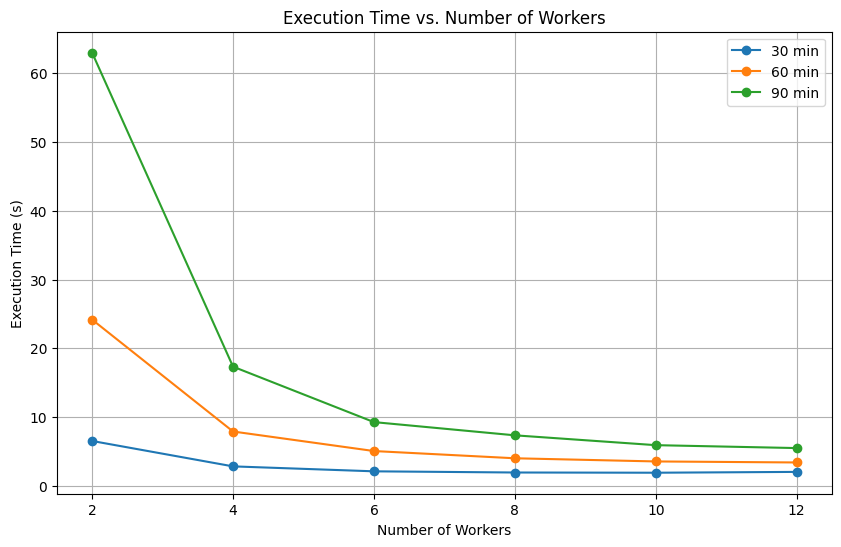

In [103]:
plt.figure(figsize=(10, 6))
for duration in [30, 60, 90]:
    subset = results_all[results_all["Duration (min)"] == duration]
    plt.plot(subset["Workers"], subset["Time (s)"], marker='o', label=f"{duration} min")

plt.title("Execution Time vs. Number of Workers")
plt.xlabel("Number of Workers")
plt.ylabel("Execution Time (s)")
plt.legend()
plt.grid(True)
plt.show()

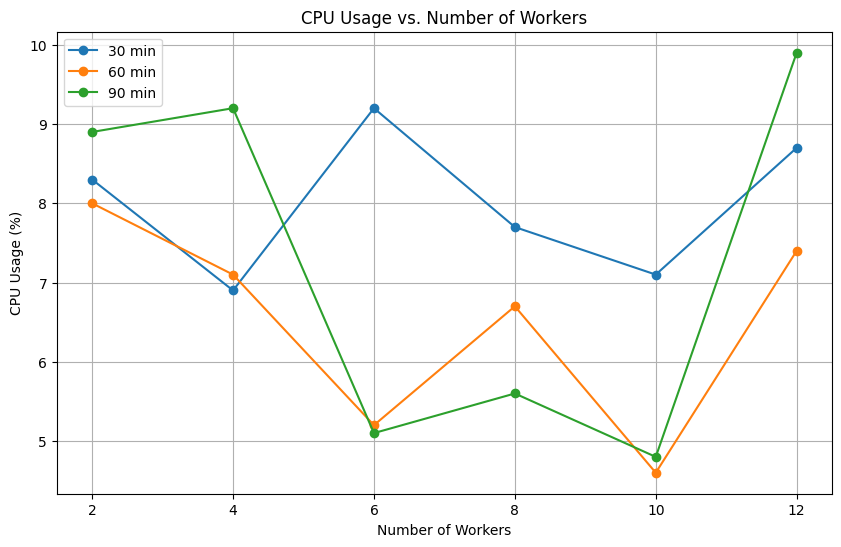

In [104]:
plt.figure(figsize=(10, 6))
for duration in [30, 60, 90]:
    subset = results_all[results_all["Duration (min)"] == duration]
    plt.plot(subset["Workers"], subset["CPU (%)"], marker='o', label=f"{duration} min")

plt.title("CPU Usage vs. Number of Workers")
plt.xlabel("Number of Workers")
plt.ylabel("CPU Usage (%)")
plt.legend()
plt.grid(True)
plt.show()

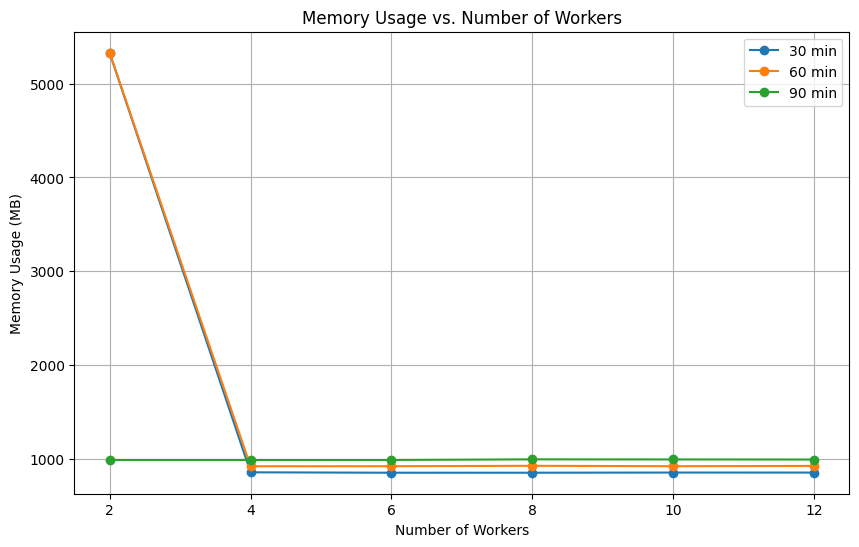

In [105]:
plt.figure(figsize=(10, 6))
for duration in [30, 60, 90]:
    subset = results_all[results_all["Duration (min)"] == duration]
    plt.plot(subset["Workers"], subset["Memory (MB)"], marker='o', label=f"{duration} min")

plt.title("Memory Usage vs. Number of Workers")
plt.xlabel("Number of Workers")
plt.ylabel("Memory Usage (MB)")
plt.legend()
plt.grid(True)
plt.show()